In [12]:
import numpy as np
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from matplotlib import gridspec
import os
%matplotlib inline

# 1 Preparation

## 1.1 Prediction algorithm description

In [13]:
classesNameNumber = {'bottle':0,'headphones':1,'human':2,'key':3,'laptop':4,'pen':5,'phone':6,'shoes':7,'sodacan':8,'wallet':9}
classesNumberName = {v:k for k, v in classesNameNumber.items()}

In [14]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.05)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.zeros(shape)
  return tf.Variable(initial)

In [15]:
graph = tf.Graph()

with graph.as_default():
    
    conv_kernel_size = 3
    conv_kernel_stride = 1
    pool_kernel_size = 2
    pool_kernel_stride = 2
    
    input_size = 224
    pool1_size = 112
    pool2_size = 56
    pool3_size = 28
    pool4_size = 14
    pool5_size = 7
    
    input_depth = 3
    block1_depth = 16
    block2_depth = 32
    block3_depth = 64
    block4_depth = 128
    block5_depth = 128
    FC1_depth = 1024
    dropout1_prob = 0.5
    FC2_depth = 1024
    dropout2_prob = 0.5
    FC_output_depth = 10
    
    conv1_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,input_depth,block1_depth])
    conv1_1_biases = bias_variable([block1_depth])
    conv1_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block1_depth])
    conv1_2_biases = bias_variable([block1_depth])
    
    conv2_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block2_depth])
    conv2_1_biases = bias_variable([block2_depth])
    conv2_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block2_depth])
    conv2_2_biases = bias_variable([block2_depth])
    
    conv3_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block3_depth])
    conv3_1_biases = bias_variable([block3_depth])
    conv3_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block3_depth])
    conv3_2_biases = bias_variable([block3_depth])
    
    conv4_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block4_depth])
    conv4_1_biases = bias_variable([block4_depth])
    conv4_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block4_depth])
    conv4_2_biases = bias_variable([block4_depth])
    
    conv5_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block5_depth])
    conv5_1_biases = bias_variable([block5_depth])
    conv5_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block5_depth,block5_depth])
    conv5_2_biases = bias_variable([block5_depth])
    
    FC1_weights = weight_variable([pool5_size,pool5_size,block5_depth,FC1_depth])
    FC1_biases = bias_variable([FC1_depth])
    FC2_weights = weight_variable([1,1,FC1_depth,FC2_depth])
    FC2_biases = bias_variable([FC2_depth])
    FC_output_weights = weight_variable([1,1,FC2_depth,FC_output_depth])
    FC_output_biases = bias_variable([FC_output_depth])
    
    saver = tf.train.Saver()
    
    def model_predict(data):
        conv1_1 = tf.nn.conv2d(data,conv1_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu1_1 = tf.nn.relu(conv1_1 + conv1_1_biases)

        conv1_2 = tf.nn.conv2d(relu1_1,conv1_2_weights,strides=[1,1,1,1],padding='SAME')
        relu1_2 = tf.nn.relu(conv1_2 + conv1_2_biases)

        pool1   = tf.nn.max_pool(relu1_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv2_1 = tf.nn.conv2d(pool1,conv2_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu2_1 = tf.nn.relu(conv2_1 + conv2_1_biases)

        conv2_2 = tf.nn.conv2d(relu2_1,conv2_2_weights,strides=[1,1,1,1], padding='SAME')
        relu2_2 = tf.nn.relu(conv2_2 + conv2_2_biases)

        pool2   = tf.nn.max_pool(relu2_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv3_1 = tf.nn.conv2d(pool2,conv3_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu3_1 = tf.nn.relu(conv3_1 + conv3_1_biases)

        conv3_2 = tf.nn.conv2d(relu3_1,conv3_2_weights,strides=[1,1,1,1],padding='SAME')
        relu3_2 = tf.nn.relu(conv3_2 + conv3_2_biases)

        pool3   = tf.nn.max_pool(relu3_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv4_1 = tf.nn.conv2d(pool3,conv4_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu4_1 = tf.nn.relu(conv4_1 + conv4_1_biases)

        conv4_2 = tf.nn.conv2d(relu4_1,conv4_2_weights,strides=[1,1,1,1],padding='SAME')
        relu4_2 = tf.nn.relu(conv4_2 + conv4_2_biases)

        pool4   = tf.nn.max_pool(relu4_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv5_1 = tf.nn.conv2d(pool4,conv5_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu5_1 = tf.nn.relu(conv5_1 + conv5_1_biases)

        conv5_2 = tf.nn.conv2d(relu5_1,conv5_2_weights,strides=[1,1,1,1],padding='SAME')
        relu5_2 = tf.nn.relu(conv5_2 + conv5_2_biases)

        pool5   = tf.nn.max_pool(relu5_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        FC1     = tf.nn.conv2d(pool5,FC1_weights,strides=[1,1,1,1],padding='VALID')
        reluFC1 = tf.nn.relu(FC1 + FC1_biases)

        FC2     = tf.nn.conv2d(reluFC1,FC2_weights,strides=[1,1,1,1],padding='VALID')
        reluFC2 = tf.nn.relu(FC2 + FC2_biases)

        FC_output = tf.nn.conv2d(reluFC2,FC_output_weights,strides=[1,1,1,1],padding='VALID') + FC_output_biases
        return tf.reshape(FC_output,[int(data.shape[0]),10])
    
    tf_one_image = tf.placeholder(tf.float32, shape=(1, input_size, input_size, input_depth))
    
    one_prediction = tf.nn.softmax(model_predict(tf_one_image))

## 1.3 Test prediction

In [16]:
training_picture_width = 256
training_picture_height = 256

In [17]:
def picture_central_crop(im):
    size = training_picture_width,training_picture_height
    im = im.resize(size)
    return im.crop((16,16,240,240)) #left,upper,right,bottom pixels of rectangle

In [18]:
def one_image_setup(file):
    im = Image.open(file).convert('RGB')
    im = picture_central_crop(im)
    pixel_depth = 255.0
    img = np.array(im).astype(np.float32)#imageio.imread(file).astype(np.float32)
    plt.imshow(np.array(im).astype(np.uint8))
    image_data = (img - pixel_depth / 2) / pixel_depth
    return np.array(image_data)

In [19]:
def one_image_prediction(img):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # not all GPU memory (1.0)
    with tf.Session(graph=graph,config=config) as session:
        saver.restore(session,'./modelTmp/modelTestSaving.ckpt')
        print('Model restored')
        pred = one_prediction.eval(feed_dict={tf_one_image:[img]})
        print()
        print('predictions:')
        for k in range(10):
            max_ind = np.argmax(pred)
            print(classesNumberName[max_ind],round(pred[0,max_ind],4))
            pred[0,max_ind] = 0.0

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt
Model restored

predictions:
bottle 0.9242
shoes 0.0612
sodacan 0.0076
human 0.0061
pen 0.0003
key 0.0003
headphones 0.0002
wallet 0.0001
phone 0.0001
laptop 0.0


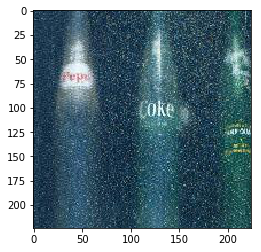

In [20]:
one_image_prediction(one_image_setup('./data/data_training/bottle/imagenetbottle0.jpg'))

# 2 Predictions

## 2.1 Photocam resize/central crop

In [29]:
def one_image_prediction(img):
    pred = one_prediction.eval(feed_dict={tf_one_image:[img]})
    string = ''
    for k in range(10):
        max_ind = np.argmax(pred)
        spaces = ''
        for kk in range(10-len(classesNumberName[max_ind])):
            spaces += '_'
        string += classesNumberName[max_ind] + ' ' + spaces + str(round(pred[0,max_ind],4)) + '\n'
        pred[0,max_ind] = 0.0
    return string

In [30]:
def predict_all_images_in_folder(folder=None):
    pixel_depth = 255.0
    grid_height = len(os.listdir(folder))
    fig = plt.figure(figsize=(5,grid_height*3))
    gs = gridspec.GridSpec(grid_height, 2, width_ratios=[1,1]) #(number of boxes in y axe, n of b in x axe,width_ratios)
    
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # not all GPU memory (1.0)
    with tf.Session(graph=graph,config=config) as session:
        saver.restore(session,'./modelTmp/modelTestSaving.ckpt')
    
        i = 0
        for file in os.listdir(folder):
            im = Image.open(folder+file).convert('RGB')
            im = picture_central_crop(im)

            img = np.array(im).astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            image_data = np.array(image_data)

            string = one_image_prediction(image_data)

            ax0 = plt.subplot(gs[i])
            ax0.axis('off')
            plt.imshow(im)
            ax1 = plt.subplot(gs[i+1])
            ax1.axis('off')
            ax1.text(0.0,0.1,string,bbox={'facecolor':'red', 'alpha':0.2, 'pad':10})
            i += 2

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt


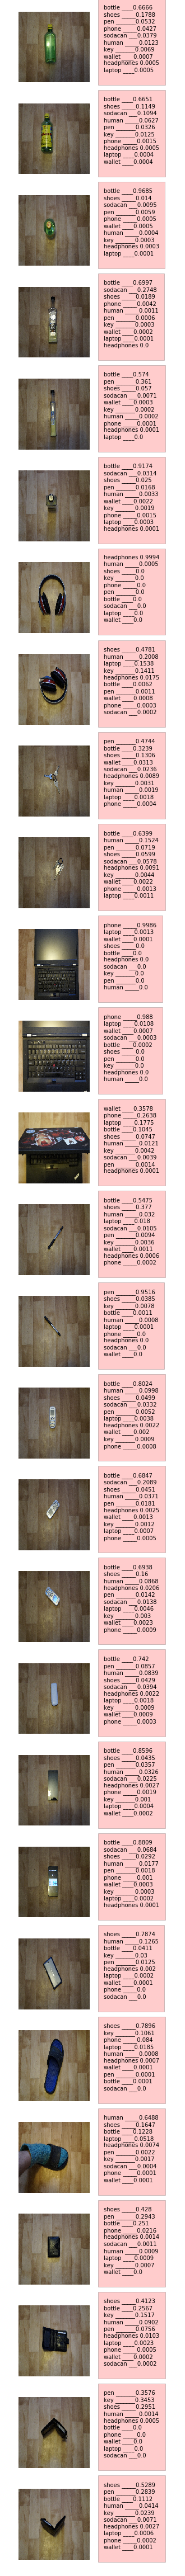

In [31]:
predict_all_images_in_folder('./photocam_vs_webcam/photocam/')

## 2.2 Photocam small width crop (to webcam aspect ratio)/resize/central crop

In [40]:
def photocam_big_central_crop(im):
    width = im.width
    height = im.height
    first_width_cropping = 614/2
    #соотношение как в вебке (обрезаем ширину на 5456-4842 = 614 px)
    im = im.crop((first_width_cropping,0,width-first_width_cropping,height))
    size = training_picture_width,training_picture_height
    im = im.resize(size)
    return im.crop((16,16,240,240)) #left,upper,right,bottom pixels of rectangle

In [41]:
def predict_all_images_in_folder2(folder=None):
    pixel_depth = 255.0
    grid_height = len(os.listdir(folder))
    fig = plt.figure(figsize=(5,grid_height*3))
    gs = gridspec.GridSpec(grid_height, 2, width_ratios=[1,1]) #(number of boxes in y axe, n of b in x axe,width_ratios)
    
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # not all GPU memory (1.0)
    with tf.Session(graph=graph,config=config) as session:
        saver.restore(session,'./modelTmp/modelTestSaving.ckpt')
    
        i = 0
        for file in os.listdir(folder):
            im = Image.open(folder+file).convert('RGB')
            im = photocam_big_central_crop(im)

            img = np.array(im).astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            image_data = np.array(image_data)

            string = one_image_prediction(image_data)

            ax0 = plt.subplot(gs[i])
            ax0.axis('off')
            plt.imshow(im)
            ax1 = plt.subplot(gs[i+1])
            ax1.axis('off')
            ax1.text(0.0,0.1,string,bbox={'facecolor':'red', 'alpha':0.2, 'pad':10})
            i += 2

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt


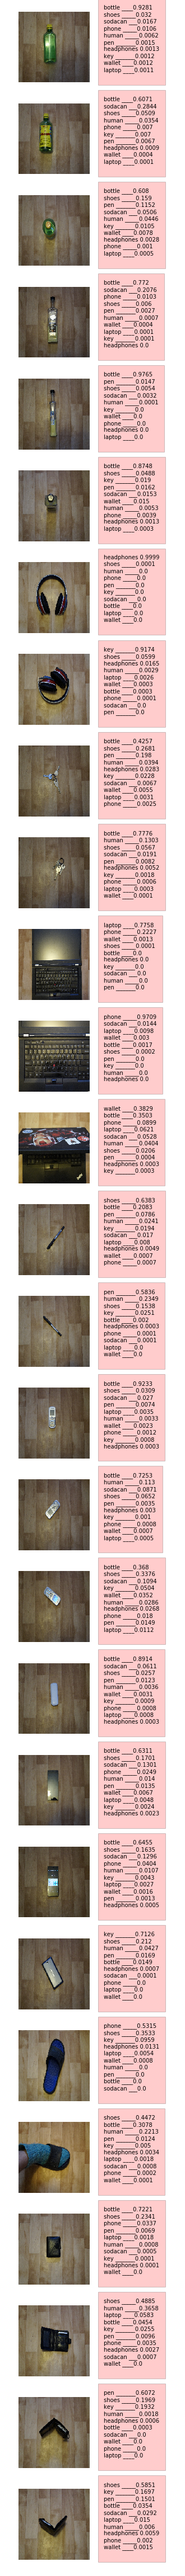

In [42]:
predict_all_images_in_folder2('./photocam_vs_webcam/photocam/')

## 2.3 Photocam width crop (to webcam aspect ratio)/big central crop/resize/central crop

In [46]:
def photocam_big_central_crop(im):
    width = im.width
    height = im.height
    first_width_cropping = 614/2
    
    #соотношение как в вебке (обрезаем ширину на 5456-4842 = 614 px)
    im = im.crop((first_width_cropping,0,width-first_width_cropping,height))
    
    #центральный пропорциональный текущему aspect ratio вырез
    big_central_crop_k = 1.3
    new_width = round(width/big_central_crop_k)
    new_height = round(height/big_central_crop_k)
    width_cropping = (width-new_width)/2
    height_cropping = (height-new_height)/2
    im = im.crop((width_cropping,height_cropping,width-first_width_cropping-width_cropping,height-height_cropping))
    
    size = training_picture_width,training_picture_height
    im = im.resize(size)
    return im.crop((16,16,240,240)) #left,upper,right,bottom pixels of rectangle

In [47]:
def predict_all_images_in_folder3(folder=None):
    pixel_depth = 255.0
    grid_height = len(os.listdir(folder))
    fig = plt.figure(figsize=(5,grid_height*3))
    gs = gridspec.GridSpec(grid_height, 2, width_ratios=[1,1]) #(number of boxes in y axe, n of b in x axe,width_ratios)
    
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # not all GPU memory (1.0)
    with tf.Session(graph=graph,config=config) as session:
        saver.restore(session,'./modelTmp/modelTestSaving.ckpt')
    
        i = 0
        for file in os.listdir(folder):
            im = Image.open(folder+file).convert('RGB')
            im = photocam_big_central_crop(im)

            img = np.array(im).astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            image_data = np.array(image_data)

            string = one_image_prediction(image_data)

            ax0 = plt.subplot(gs[i])
            ax0.axis('off')
            plt.imshow(im)
            ax1 = plt.subplot(gs[i+1])
            ax1.axis('off')
            ax1.text(0.0,0.1,string,bbox={'facecolor':'red', 'alpha':0.2, 'pad':10})
            i += 2

INFO:tensorflow:Restoring parameters from ./modelTmp/modelTestSaving.ckpt


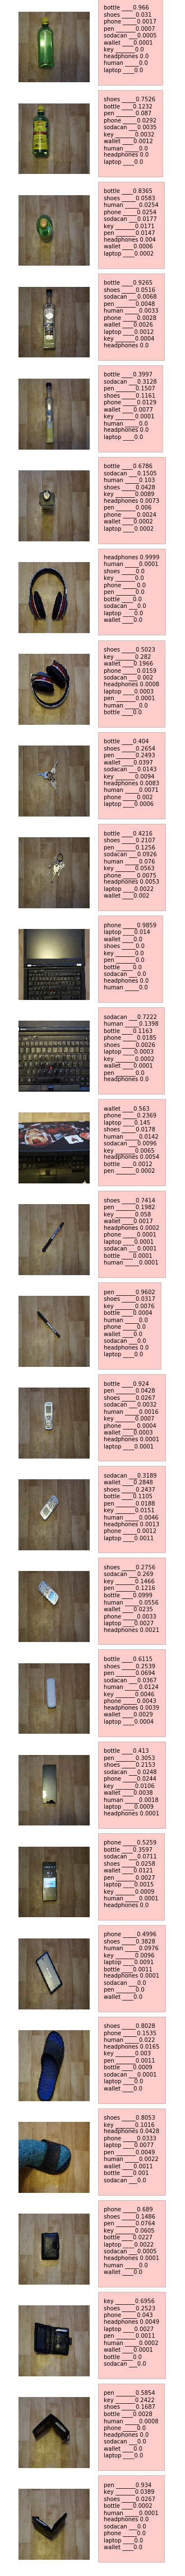

In [48]:
predict_all_images_in_folder3('./photocam_vs_webcam/photocam/')